# Analysis of the Advertising Dataset from ISLR

# Import required libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('seaborn-white')

# Preprocessing libraries
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

# Scipy
from scipy import stats

# Statsmodel
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Model libraries
from sklearn.linear_model import LinearRegression

In [2]:
# Set some plotting and printing ptions
mpl.rc('axes', labelsize = 30)
mpl.rc('axes', titlesize = 30)
mpl.rc('xtick', labelsize = 20)
mpl.rc('ytick', labelsize = 20)
mpl.rc('legend', fontsize = 20)
mpl.rc('figure', titlesize = 40)

pd.set_option('precision', 4) # Print 4 decimal places for all output parameters

# Load dataset 

## Read the data as a dataframe

In [3]:
adv_csv_path = "Datasets/Advertising.csv" # Path of csv file
df_orig = pd.read_csv(adv_csv_path, index_col = 0) # Load csv file into a Dataframe
display(df_orig.head())

,TV,radio,newspaper,sales
1,230.1,37.8,69.2,22.1
2,44.5,39.3,45.1,10.4
3,17.2,45.9,69.3,9.3
4,151.5,41.3,58.5,18.5
5,180.8,10.8,58.4,12.9


<b>The above dataframe shows sales in thousands of units as a function of TV, radio and newspaper budgets in thousands of dollars for 200 different markets.</b>

## Data Types of each attribute

In [4]:
# Print the data types of all columns
df_orig.dtypes

TV           float64
radio        float64
newspaper    float64
sales        float64
dtype: object

<b>All columns are numeric with float64 dtype</b>

## Shape of the data

In [5]:
df_orig.shape

(200, 4)

<b>There are 200 entries and 4 columns</b>

## Check for missing values

In [6]:
df_orig.isna().sum()

TV           0
radio        0
newspaper    0
sales        0
dtype: int64

<b>No missing values in any of the columns.</b>

## Correlation matrix

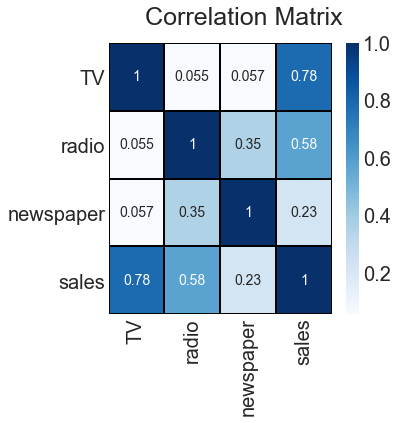

array([[ True,  True,  True,  True],
       [False,  True,  True,  True],
       [False, False,  True,  True],
       [False, False, False,  True]])

In [59]:
corr_mat = df_orig.corr()
fig = plt.figure(figsize = (5, 5))
fig.suptitle("Correlation Matrix", fontsize = 25)

# Create a mask
mask = np.triu(np.ones_like(corr_mat, dtype = bool))

sns.heatmap(corr_mat, annot_kws = {"fontsize": 14}, linewidths = 1,\
            linecolor = 'black', cmap = 'Blues', annot = True ,fmt = '.2g', cbar = True)
# sns.heatmap(corr_mat, mask = mask, annot_kws = {"fontsize": 14}, cmap = 'Blues',\
#             annot = True ,fmt = '.2g', cbar = True)
plt.show()
mask

# EDA on the dataset

# Simple Linear Regression

Based on Section 3.1 of ISLR

## Coefficients - SLR of Sales on TV

In [7]:
# Coefficients measured using a Simple Linear Regression Fit

X = df_orig[['TV']] # Predictor 'TV' captured in X
y = df_orig['sales'] # Response 'sales' captured in y

lr = LinearRegression() # Instantiate Linear Regression model
lr.fit(X, y) # Fit model

print(f"Shape of X is {X.shape}")
print(f"Shape of y is {y.shape}")
print()
print("Intercept (beta_0) is %0.4f" %lr.intercept_)
print("Coefficient (beta_1) is %0.4f" %lr.coef_)

Shape of X is (200, 1)
Shape of y is (200,)

Intercept (beta_0) is 7.0326
Coefficient (beta_1) is 0.0475


In [8]:
# Coefficients calculated using eqn (3.4), pg. 62 of ISLR

Xi = np.array(df_orig['TV']) # # Predictor 'TV' captured in Xi
Xib = np.mean(Xi) # Mean of Xi
yi = np.array(df_orig['sales']) # Response 'sales' captured in yi
yib = np.mean(yi) # Mean of yi

# Calculate beta_1 and beta_0 using eqn (3.4)
beta_1_calc = np.sum((Xi - Xib) * (yi - yib)) / np.sum((Xi - Xib) ** 2)
beta_0_calc = yib - beta_1_calc * Xib

print("Intercept (beta_0) is %0.4f" %beta_0_calc)
print("Coefficient (beta_1) is %0.4f" %beta_1_calc)

Intercept (beta_0) is 7.0326
Coefficient (beta_1) is 0.0475


## Figure 3.1 (ISLR, Pg 62)

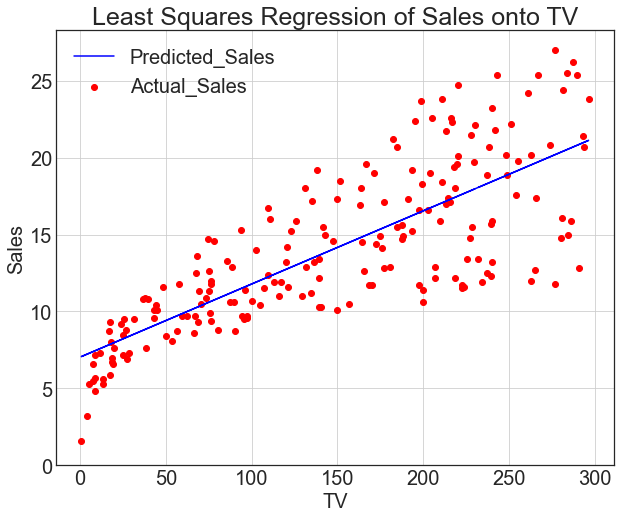

In [9]:
plt.figure(figsize = (10, 8))
y_pred = lr.predict(X) # Get predicted response based on linear fit
plt.scatter(X, y, color = 'r', label = 'Actual_Sales') # Plot 'sales' vs. 'TV'
plt.plot(X, y_pred, color = 'b', label = 'Predicted_Sales') # Plot 'predicted_sales' vs. 'TV'
plt.grid()
plt.title('Least Squares Regression of Sales onto TV', fontsize = 25)
plt.xlabel('TV', fontsize = 20)
plt.ylabel('Sales', fontsize = 20)
plt.legend(fontsize = 20)
plt.ylim(ymin = 0);

## SLR using statsmodels

In [10]:
# OLS regression of Sales onto TV
lm = smf.ols('sales ~ TV', data = df_orig).fit()
lm.summary().tables[1] # Table 3.1, pg. 68 of ISLR

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,7.0326,0.458,15.360,0.000,6.130,7.935
TV,0.0475,0.003,17.668,0.000,0.042,0.053


In [11]:
# Manual computation of std.err, t-coef, p-value and confidence intervals
RSS = np.sum((y - y_pred) ** 2) # Eqn. (3.3), pg. 62 of ISLR
x_spr = np.sum((Xi - Xib) ** 2)  
SE_beta1 = np.sqrt(RSS / ((y.shape[0] - 2) * x_spr)) # Eqn. (3.8), pg. 66 of ISLR
tst_beta1 = lm.params['TV'] / SE_beta1
p_val = 2 * stats.t.cdf(-tst_beta1, df = (y.shape[0] - 2))

# Obtain 95% confidence intervals (Eqn. (3.9) to (3.11) pg. 66 of ISLR)
t_cr_0P95 = stats.t.ppf(0.025, df = (y.shape[0] - 2)) # t-critical corresponding to 95% CI
ci_low = lm.params['TV'] + t_cr_0P95 * SE_beta1 # Lower CI value
ci_upp = lm.params['TV'] - t_cr_0P95 * SE_beta1 # Upper CI value

print("t-statistic of TV coefficient (beta_1) is %0.4f" %tst_beta1)
print('p-value corresponding to above t-statistics is %0.2e' %p_val)
print()
print("Lower CI value at (95%% CL) is %0.3f" %(ci_low))
print("Upper CI value at (95%% CL) is %0.3f" %(ci_upp))

t-statistic of TV coefficient (beta_1) is 17.6676
p-value corresponding to above t-statistics is 1.47e-42

Lower CI value at (95% CL) is 0.042
Upper CI value at (95% CL) is 0.053


<b>Since the p-value corresponding to $\beta1$ is very small, we can conclude that $\beta1$ $\neq$ 0, which implies that sales are related to TV advertising budget.</b> 

## Interpretation of CI values

Intercept coefficient (beta_0) has a mean of 7.0326 and 95% CI limits of (6.130, 7.935). This implies that in the absence of any TV advertising budget, the sales will, on average, fall somewhere between 6130 and 7935 units.


Slope of sales vs. TV (beta_1) has a mean of 0.0475 with a 95% CI limits of (0.042, 0.053). This implies that, for a $1000 increase in TV advertising, there will be an average increase in sale of between 42 and 53 units.

## Accuracy of the SLR fit

Based on Section 3.1.3, pg. 68 - 72 of ISLR

### RSE

In [24]:
TSS = np.sum((yi - yib) ** 2) # Total sum of squares = total variance in response y
RSS = np.sum((y - y_pred) ** 2) # Residual sum of squares = residual variance after SLR fit
var_expl = TSS - RSS
std_dev_y = np.sqrt(TSS / y.shape[0]) # Standard deviation of response y
RSE = np.sqrt(RSS / ((y.shape[0] - 2))) # Eqn. 3.15, pg. 69 of ISLR
print(f"TSS: Total Variance in response y is {TSS:0.2f}")
print(f"RSS: Residual variance in response y after SLR fit of Sales onto TV is {RSS:0.2f}")
print(f"Varaince explained by SLR fit of Sales onto TV is {var_expl:0.2f}")
print()
print(f"Original standard deviation of sales is {std_dev_y:0.4f}")
print(f"RSE of SLR fit of Sales onto TV is {RSE:0.4f}")        

TSS: Total Variance in response y is 5417.15
RSS: Residual variance in response y after SLR fit of Sales onto TV is 2102.53
Varaince explained by SLR fit of Sales onto TV is 3314.62

Original standard deviation of sales is 5.2044
RSE of SLR fit of Sales onto TV is 3.2587


<b>Interpretation of Original standard deviation:</b> Actual sales in each market deviates from the mean sales (across all markets) by approximately 5200 units on average.

<b>Interpretation of RSE:</b> Actual sales in each market deviates from the true regression line (Sales vs. TV linear fit) by approximately 3260 units on average. This implies that the SLR fit of Sales onto TV is able to explain some amount of the variance in the sales data across markets.

<b>RSE</b> provides an absolute measure of lack of fit and is measured in units of the response variable sales. <b>$R^2$</b>statistic provides a normalized measure.

### $R^2$

In [34]:
Rsq = var_expl / TSS
print(f"R_squared (Manual Calculation) is {Rsq:0.4f}")
print(f"R_squared (StatsModels) is {lm.rsquared:0.4f}")
print(f"R_squared (StatsModels) is {lm.rsquared:0.4f}")
print(f"R_squared (LinearRegression) is {lr.score(X, y):0.4f}")

R_squared (Manual Calculation) is 0.6119
R_squared (StatsModels) is 0.6119
R_squared (StatsModels) is 0.6119
R_squared (LinearRegression) is 0.6119


<b>$R^2$ = 0.62 implies that around 3/5th of the total variance in Sales is explained by the SLR fit of Sales onto TV.</b>

## Coefficients - SLR of Sales onto TV, Radio, newspaperm

In [36]:
# OLS regression of Sales onto TV
lm = smf.ols('sales ~ TV', data = df_orig).fit()
lm.summary().tables[1] # Table 3.1, pg. 68 of ISLR

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,7.0326,0.458,15.360,0.000,6.130,7.935
TV,0.0475,0.003,17.668,0.000,0.042,0.053


In [37]:
# OLS regression of Sales onto radio
lm = smf.ols('sales ~ radio', data = df_orig).fit()
lm.summary().tables[1] # Table 3.3, pg. 72 of ISLR

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,9.3116,0.563,16.542,0.000,8.202,10.422
radio,0.2025,0.020,9.921,0.000,0.162,0.243


<b>A $1000 increase in radio advertising budget is associated with an average increase in sales of around 203 units.</b>

In [39]:
# OLS regression of Sales onto newspaper
lm = smf.ols('sales ~ newspaper', data = df_orig).fit()
lm.summary().tables[1] # Table 3.3, pg. 72 of ISLR

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,12.3514,0.621,19.876,0.000,11.126,13.577
newspaper,0.0547,0.017,3.300,0.001,0.022,0.087


<b>A $1000 increase in newspaper advertising budget is associated with an average increase in sales of around 55 units.</b>

# Multiple Linear Regression

## MLR using statsmodel

In [44]:
lm = smf.ols('sales ~ TV + radio + newspaper', data = df_orig).fit()
lm.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,2.9389,0.312,9.422,0.000,2.324,3.554
TV,0.0458,0.001,32.809,0.000,0.043,0.049
radio,0.1885,0.009,21.893,0.000,0.172,0.206
newspaper,-0.0010,0.006,-0.177,0.860,-0.013,0.011


<b>Interpretation of above results:</b>

1. For a given amount of TV and newspaper advertising, spending an additional $1000 on newspaper spending leads to an increase in sales of around 189 units.
2. MLR coefficients for TV an radio are quite similar to the SLR coefficients but the coefficient for newspaper is significantly different and close to zero. Also, the associated p-value is very high which implies that we cannot reject the null hypothesis that newspaper advertising has no impact on sales.
3. Reason for the difference in regression coefficient for newspaper between SLR and MLR is because of the fact that radio and newspaper are positively correlated (see correlation matrix section above) with a correlation coefficient of 0.35

## Q1: Is there a relationship between predictors and sales

Goal is to test the null-hypothesis:

$H_{0}$: $\beta_{1}$ = $\beta_{2}$ = ... = $\beta_{p}$ = 0 versus the alternative:

$H_{A}$: Atleast one $\beta_{j}$ is non-zero.

This is equivalent to doing an ANOVA test and F-statistic has to be used.

In [68]:
# Table 3.6, Pg. 76 of ISLR
print(f"F-statistic of MLR of sales onto TV, Radio, Newspaper is {lm.fvalue:0.2f}")
print(f"P-Value associated with F-statistics is {lm.f_pvalue:0.2e}")

F-statistic of MLR of sales onto TV, Radio, Newspaper is 570.27
P-Value associated with F-statistics is 1.58e-96


<b>Since F-statistic is very high and associated P-value is very small, we can conclude that atleast one of the regression coefficients is non-zero and has an impact on sales.</b>

## Q3: Accuracy of model fit

In [67]:
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  sales   R-squared:                       0.897
Model:                            OLS   Adj. R-squared:                  0.896
Method:                 Least Squares   F-statistic:                     570.3
Date:                Sun, 16 May 2021   Prob (F-statistic):           1.58e-96
Time:                        18:50:37   Log-Likelihood:                -386.18
No. Observations:                 200   AIC:                             780.4
Df Residuals:                     196   BIC:                             793.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.9389      0.312      9.422      0.000       2.324       3.554
TV             0.0458      0.001     32.809      0.000       0.043       0.049
radio          0.1885      0.009     21.893      0.000       0.172       0.206
newspaper     -0.0010      0.006     -0.177      0.860      -0.013       0.011
==============================================================================
Omnibus:                       60.414   Durbin-Watson:                   2.084
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              151.241
Skew:                          -1.327   Prob(JB):                     1.44e-33
Kurtosis:                       6.332   Cond. No.                         454.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""